In [2]:
import numpy as np 
from Environment import Easy21
import matplotlib.pyplot as plt
from utils import *

<h2>Theoretical value function</h2>

In [3]:
value_star = np.load("results/theoretical_value_function.npy")

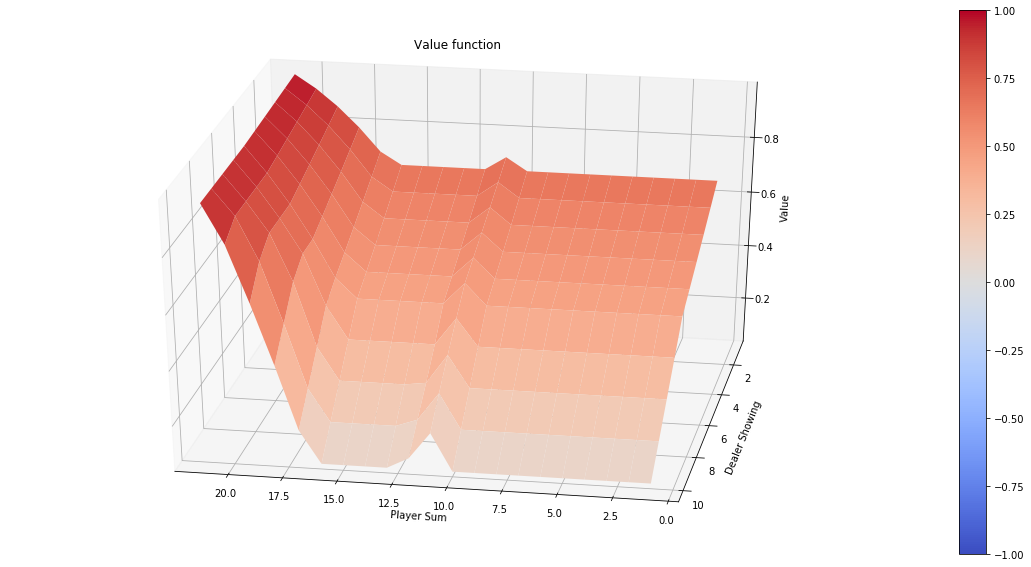

In [4]:
plot_value_function(value_star, degree= 100, cm = plt.cm.coolwarm)

<h2>Params</h2>

In [5]:
#Params
N0 = 100
discount_factor = 1


<h2>TD Lambda</h2>

In [11]:
##TD
iterations = int(2e4)
lambdas = [i/10 for i in range(11)]
MSEs_all = []
plt.clf()
"""
for i in range(len(lambdas)):
    MSEs,action_value= td_lambda_backward_view(iterations, N0, discount_factor, lambdas[i], value_star)
    MSEs_all.append(MSEs)
"""
MSEs_all= np.load("results/MSE_differentLambdas.npy")

<h3>Comparing performance for different lambdas</h3>

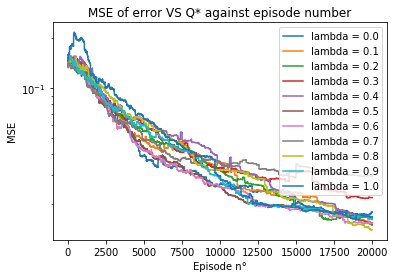

In [17]:
episodes = [i for i in range(iterations)]

for k in range(len(lambdas)):
    plt.plot(episodes, MSEs_all[k])
    
plt.xlabel("Episode n°")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend(["lambda = " + str(Lambda) for Lambda in lambdas])
plt.title("MSE of error VS Q* against episode number")

plt.show()

<h2>Plot mean-squared error against Lambda</h2>

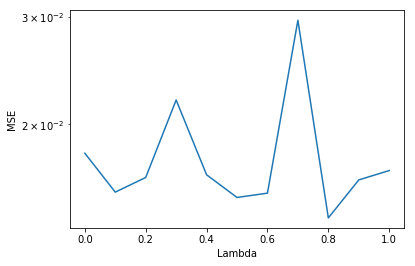

In [15]:
mses_lambdas = []
for i in range (len(lambdas)):
    last_mse_lambda_i = MSEs_all[i][-1]
    mses_lambdas.append(last_mse_lambda_i)
plt.clf()
plt.ylabel("MSE")
plt.xlabel("Lambda")
plt.yscale("log")
plt.plot(lambdas, mses_lambdas)
plt.show()

<h3>Plot value function for a specific lambda</h3>

In [7]:
iterations = int(1e5)
episodes_comparison = [i for i in range(iterations)]
MSEs_montecarlo, av_mc = td_lambda_backward_view(iterations, N0, discount_factor, 1, value_star)
MSEs_td0, av_td0 = td_lambda_backward_view(iterations, N0, discount_factor, 0, value_star)


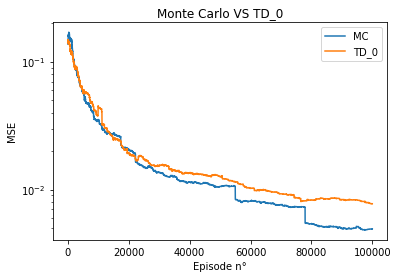

In [22]:
plt.clf()
plt.plot(episodes_comparison, MSEs_montecarlo)
plt.plot(episodes_comparison, MSEs_td0)
plt.legend(["MC", "TD_0"])
plt.ylabel("MSE")
plt.yscale("log")
plt.xlabel("Episode n°")
plt.title("Monte Carlo VS TD_0")
plt.show()